In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv = 300
conn_prob = 1

In [3]:
peak_rate, kernel_width = 150, 10

In [4]:
T_rend = 100 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(1, N_Aiv))
# ( 1, Number of renditions )
burst_ts = np.array([[T_rend * (j + 1/2) for j in range(N_rend)]])
save_W_ts = (burst_ts[0] + T_rend / 2 - 1).astype(int) # [0] to squeeze

In [6]:
_ = rng.standard_normal((1, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = np.tile(syl, (T, 1))

In [8]:
rmax, s, th = 100, 1, 4
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1, 0.1
JEE, JEI, JIE, JII = np.zeros(4)
tau_Aiv, tau_I, dt = 20, 10, 1

net = Aiv(N_Aiv, 1, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
          tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.1, ext_I, bilin_hebb,
            lr=-5e-7, w0_mean=w0_mean, tau_w=5e7)
rA, rI, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

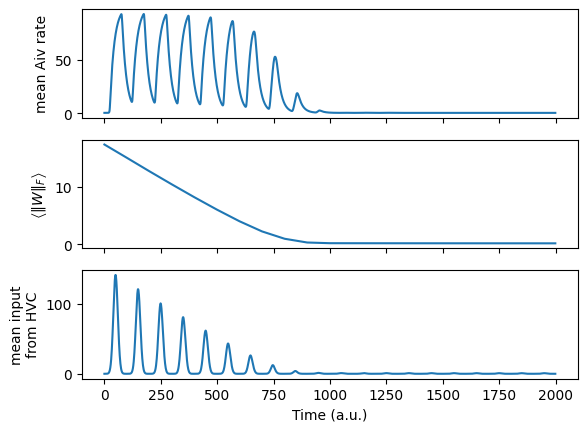

In [11]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [12]:
W_syl_corrs = [correlation(_.T, syl, lambda x: x) for _ in Ws]

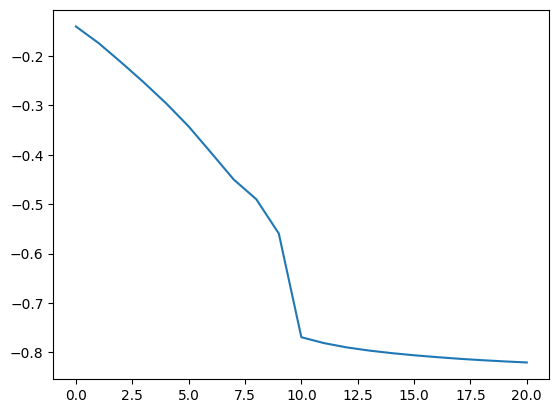

In [13]:
plt.plot(list(map(lambda x: x.flatten(), W_syl_corrs)))

0.8611443432961328

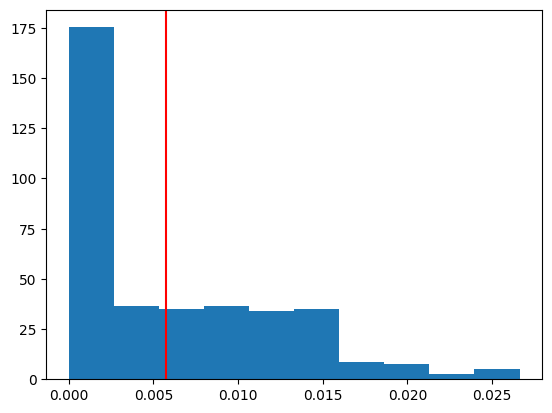

In [14]:
plt.hist(Ws[-1].flatten(), density=True, bins=10)
plt.axvline(Ws[-1].mean(), color='r')
# plt.axvline(w0_mean, color='k')
Ws[-1].mean() * peak_rate

In [15]:
def noisy_input(eps0, sig, tau, repeat, rH=peak_rate):
    _T_rend, dt = 5000, 0.1
    rA = np.zeros((repeat, _T_rend, N_Aiv))
    rI = np.zeros((repeat, _T_rend))
    
    rH_ = np.zeros((_T_rend, 1)) + rH
    
    aud = np.tile(syl, (_T_rend, 1))
    noise = np.zeros((repeat, _T_rend, N_Aiv))
    for i in tqdm(range(repeat)):
        Aiv0, I0 = rng.random(N_Aiv), 1
        noise[i,0] = eps0
        for t in range(1, _T_rend):
            dn = (-noise[i,t-1] + eps0 + rng.normal(scale=sig, size=N_Aiv)) / tau
            noise[i,t] = noise[i,t-1] + dn * dt
    
        rA[i], rI[i] = net.sim(Aiv0, I0, rH_, aud+noise[i], [], 
                               _T_rend, dt, 0, ext_I)[:2]
    ts = np.arange(0, _T_rend*0.1, 0.1)
    return ts, rA, rI, noise

## Low noise

In [16]:
ts, rA, rI, noise = noisy_input(0, 10, 30, repeat=30)

100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.40it/s]


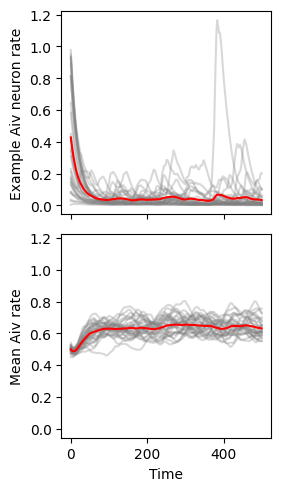

In [17]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

Text(0, 0.5, '$\\xi_i$')

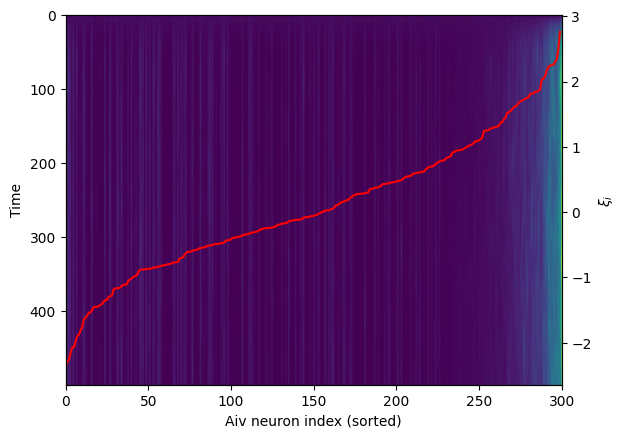

In [18]:
fig, ax = plt.subplots(1)
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
          extent=[0, N_Aiv, *ts[[-1,0]]])
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')

In [19]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
aux = rA[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for i in tqdm(range(rA.shape[0])):
    for j in range(N_Aiv):
        ac_A[i,:,j] = np.correlate(aux[i,:,j], aux[i,:,j], mode='full')[aux.shape[1]-1:]
ac_A /= ac_A.shape[1]

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 99.08it/s]


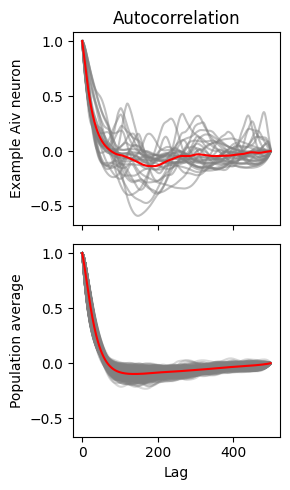

In [20]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Population average')
fig.tight_layout()

[Text(0, 0.5, '% Active')]

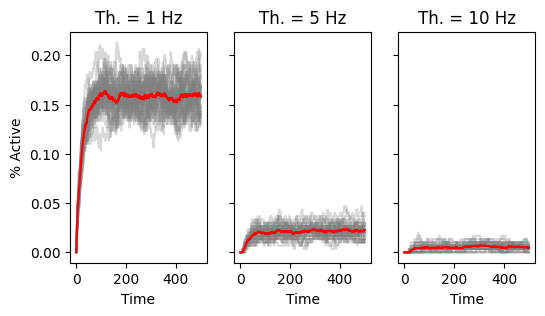

In [21]:
ths = (1, 5, 10)
fig, ax = plt.subplots(1, len(ths), sharex='all', sharey='all', figsize=(6, 3))
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=-1).T / N_Aiv
    ax[i].plot(ts, s1, c='grey', alpha=0.3)
    ax[i].plot(ts, s1.mean(axis=1), c='r')
    ax[i].set(xlabel='Time', title='Th. = %d Hz' % _)
ax[0].set(ylabel='% Active')

Text(0, 0.5, 'Density')

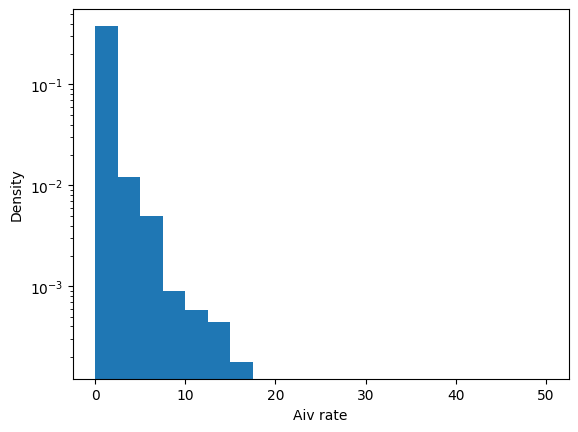

In [22]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 50), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')

## High noise

In [23]:
ts, rA, rI, noise = noisy_input(0, 15, 30, repeat=30)

100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.32it/s]


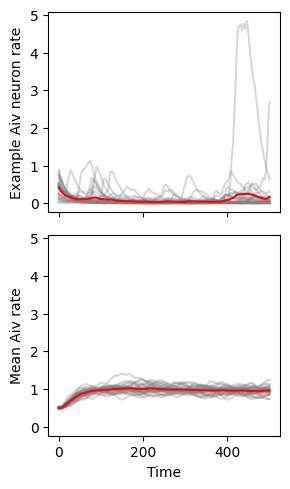

In [24]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

Text(0, 0.5, '$\\xi_i$')

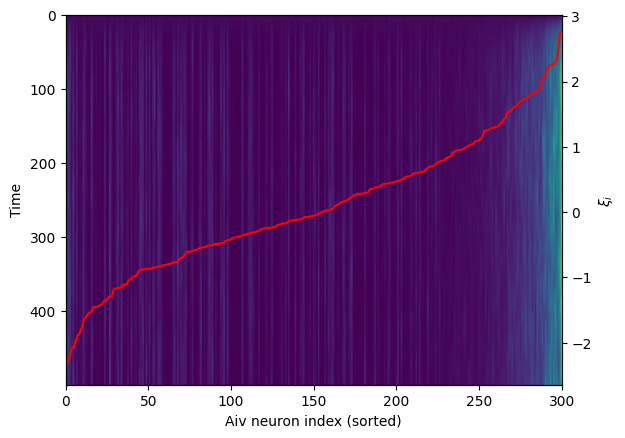

In [25]:
fig, ax = plt.subplots(1)
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
          extent=[0, N_Aiv, *ts[[-1,0]]])
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')

In [26]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
aux = rA[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for i in tqdm(range(rA.shape[0])):
    for j in range(N_Aiv):
        ac_A[i,:,j] = np.correlate(aux[i,:,j], aux[i,:,j], mode='full')[aux.shape[1]-1:]
ac_A /= ac_A.shape[1]

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 90.68it/s]


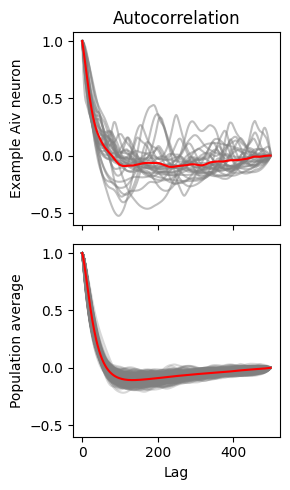

In [27]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Population average')
fig.tight_layout()

[Text(0, 0.5, '% Active')]

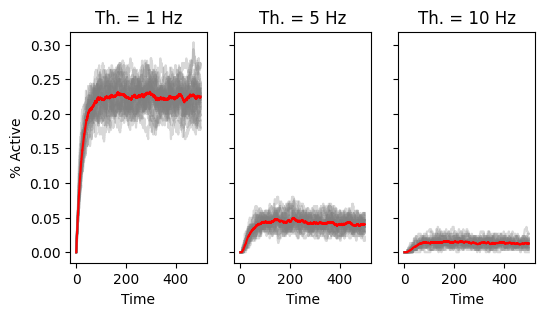

In [28]:
ths = (1, 5, 10)
fig, ax = plt.subplots(1, len(ths), sharex='all', sharey='all', figsize=(6, 3))
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=-1).T / N_Aiv
    ax[i].plot(ts, s1, c='grey', alpha=0.3)
    ax[i].plot(ts, s1.mean(axis=1), c='r')
    ax[i].set(xlabel='Time', title='Th. = %d Hz' % _)
ax[0].set(ylabel='% Active')

Text(0, 0.5, 'Density')

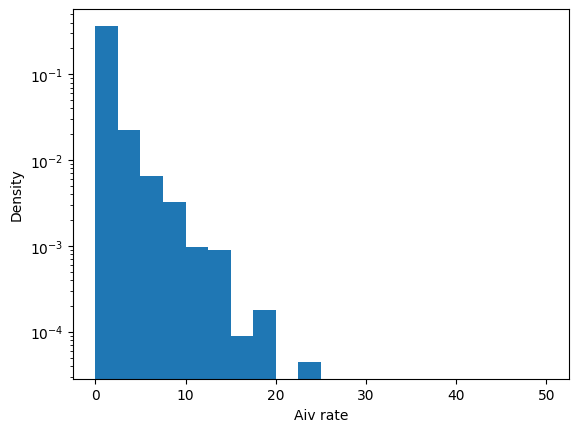

In [29]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 50), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')